# Integration of Single Hyperbox-based Models with Sklearn Pipeline and Hyperopt

This example shows how to integrate the GFMM classifier into the Pipeline class implemented by scikit-learn

Note that this example is illustrated by using the original online learning algorithm for GFMM model. However, it can be used for any GFMM models using other learning algorithms

In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from hbbrain.numerical_data.incremental_learner.onln_gfmm import OnlineGFMM

#### Load Iris dataset and prepare training and testing sets

In [2]:
from sklearn.datasets import load_iris

In [3]:
df = load_iris()
X = df.data
y = df.target

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

#### Create a pipeline of pre-processing method (i.e., normalization of data in the range of [0, 1]) and a GFMM classifier. Note: the GFMM classifier using an original online learning algorithm requires the input data in the range of [0, 1].

In [5]:
theta = 0.1
theta_min = 0.1
onln_gfmm_clf = OnlineGFMM(theta=theta, theta_min=theta_min)

In [6]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('onln_gfmm', onln_gfmm_clf)])

#### Training

In [7]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('onln_gfmm',
                 OnlineGFMM(C=array([2, 1, 0, 2, 2, 1, 0, 1, 1, 1, 2, 0, 0, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       1, 2, 1, 1, 2, 0, 1, 0, 0, 1, 0, 1, 2, 2, 0, 2, 0, 2, 1, 1, 0, 2,
       2, 0, 0, 2, 2, 1, 1, 0, 1, 0, 2, 1]),
                            V=array([[0.58333333, 0.41666667, 0.68965517, 0.70833333],
       [0.30555556, 0.41666667, 0.5862069 , 0.58333333],
       [0.19444444, 0.625     , 0.05172414, 0.04166667],
       [0.44444444, 0.416666...
       [0.86111111, 0.33333333, 0.86206897, 0.75      ],
       [0.38888889, 0.25      , 0.44827586, 0.375     ],
       [0.66666667, 0.41666667, 0.67241379, 0.66666667],
       [0.19444444, 0.41666667, 0.0862069 , 0.04166667],
       [0.44444444, 0.5       , 0.63793103, 0.70833333],
       [0.33333333, 0.625     , 0.03448276, 0.04166667],
       [0.55555556, 0.375     , 0.77586207, 0.70833333],
       [0.41666667, 0.29166667, 0.51724138, 0.375     ]]),
              

#### Testing

In [8]:
acc = pipe.score(X_test, y_test)
print(f'Testing accuracy = {acc * 100: .2f}%')

>>> The testing sample 26 with the coordinate [ 0.08333333  0.66666667 -0.01724138  0.04166667] is outside the range [0, 1]. Membership value = 0.916667. The prediction is more likely incorrect.
Testing accuracy =  96.67%


## The example below shows how to use the HyperOpt library in combination with PipleLine and Cross-validation to find the best model

In [9]:
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

#### Define search space

In [10]:
hp_space_gfmm = {
    'theta': hp.uniform('theta', 0, 1), 
    'gamma': hp.uniform('gamma', 0, 10)
}

# Draw random sample to see if hyperspace is correctly defined
ho_sample(hp_space_gfmm)

{'gamma': 4.542173063848446, 'theta': 0.8064001273117817}

#### Defining model

In [11]:
def init_model(hps):
    """
    Constructs estimator
    
    Parameters:
    ----------------
    hps : sample point from search space
    
    Returns:
    ----------------
    model : sklearn.Pipeline.pipeline with hyperparameters set up as per hps
    """
    
    # Assembing pipeline
    model = Pipeline([
        ('scale', MinMaxScaler()), 
        ('clf', OnlineGFMM(**hps))
    ])
    
    return model

In [12]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score

### Define target function

#### Now we have to define function to minimize. We'll stick with cross-validation score on train set. Our function should take a sample from search space and return negative mean Acc score. As noted above, it is very important to return negative score here, since otherwise we'll seek for hyperparameters that minimize Acc

In [13]:
def f_to_min1(hps, X, y, ncv=5):
    """
    Target function for optimization
    
    Parameters:
    ----------------
    hps : sample point from search space
    X : feature matrix
    y : target array
    ncv : number of folds for cross-validation
    
    Returns:
    ----------------
    : target function value (negative mean cross-val Acc score)
    """
    
    model = init_model(hps)
    cv_res = cross_val_score(model, X, y, cv=StratifiedKFold(ncv, shuffle=True, random_state=0), 
                             scoring='accuracy', n_jobs=1)
    
    return -cv_res.mean()

#### Running optimization

In [14]:
from functools import partial
import numpy as np

#### All right, let's run optimization for 100 rounds using TPE algorithm, meaning that we use TPE to suggest next sample values based on previous function evaluations. We'll use Trials class objects to keep track of optimization history. Note: We're binding X and y arguments of target function to X_train and y_train respectively, using functools.partial, since target function of fmin may accept only a search space point.

In [15]:
trials_clf = Trials()
best_clf = fmin(partial(f_to_min1, X=X_train, y=y_train), 
                 hp_space_gfmm, algo=tpe.suggest, max_evals=100, 
                 trials=trials_clf, rstate = np.random.default_rng(0))

>>> The testing sample 19 with the coordinate [1.05882353 0.75       0.9137931  0.79166667] is outside the range [0, 1]. Membership value = 0.888627. The prediction is more likely incorrect.
>>> The testing sample 11 with the coordinate [-0.02857143  0.41666667 -0.01818182  0.        ] is outside the range [0, 1]. Membership value = 0.945905. The prediction is more likely incorrect.
>>> The testing sample 21 with the coordinate [0.94285714 0.25       1.03636364 0.91666667] is outside the range [0, 1]. Membership value = 0.842222. The prediction is more likely incorrect.
>>> The testing sample 6 with the coordinate [ 0.19444444 -0.10526316  0.4137931   0.375     ] is outside the range [0, 1]. Membership value = 0.800702. The prediction is more likely incorrect.
>>> The testing sample 12 with the coordinate [0.38888889 1.15789474 0.06896552 0.125     ] is outside the range [0, 1]. Membership value = 0.701052. The prediction is more likely incorrect.
>>> The testing sample 19 with the coo

>>> The testing sample 12 with the coordinate [0.38888889 1.15789474 0.06896552 0.125     ] is outside the range [0, 1]. Membership value = 0.381343. The prediction is more likely incorrect.
>>> The testing sample 19 with the coordinate [1.05882353 0.75       0.9137931  0.79166667] is outside the range [0, 1]. Membership value = 0.738973. The prediction is more likely incorrect.
>>> The testing sample 11 with the coordinate [-0.02857143  0.41666667 -0.01818182  0.        ] is outside the range [0, 1]. Membership value = 0.886097. The prediction is more likely incorrect.
>>> The testing sample 21 with the coordinate [0.94285714 0.25       1.03636364 0.91666667] is outside the range [0, 1]. Membership value = 0.738973. The prediction is more likely incorrect.
>>> The testing sample 6 with the coordinate [ 0.19444444 -0.10526316  0.4137931   0.375     ] is outside the range [0, 1]. Membership value = 0.505423. The prediction is more likely incorrect.
>>> The testing sample 12 with the coo

>>> The testing sample 6 with the coordinate [ 0.19444444 -0.10526316  0.4137931   0.375     ] is outside the range [0, 1]. Membership value = 0.532177. The prediction is more likely incorrect.
>>> The testing sample 12 with the coordinate [0.38888889 1.15789474 0.06896552 0.125     ] is outside the range [0, 1]. Membership value = 0.468160. The prediction is more likely incorrect.
>>> The testing sample 19 with the coordinate [1.05882353 0.75       0.9137931  0.79166667] is outside the range [0, 1]. Membership value = 0.398965. The prediction is more likely incorrect.
>>> The testing sample 11 with the coordinate [-0.02857143  0.41666667 -0.01818182  0.        ] is outside the range [0, 1]. Membership value = 0.737730. The prediction is more likely incorrect.
>>> The testing sample 21 with the coordinate [0.94285714 0.25       1.03636364 0.91666667] is outside the range [0, 1]. Membership value = 0.398965. The prediction is more likely incorrect.
>>> The testing sample 6 with the coor

>>> The testing sample 21 with the coordinate [0.94285714 0.25       1.03636364 0.91666667] is outside the range [0, 1]. Membership value = 0.864965. The prediction is more likely incorrect.
>>> The testing sample 6 with the coordinate [ 0.19444444 -0.10526316  0.4137931   0.375     ] is outside the range [0, 1]. Membership value = 0.744145. The prediction is more likely incorrect.
>>> The testing sample 12 with the coordinate [0.38888889 1.15789474 0.06896552 0.125     ] is outside the range [0, 1]. Membership value = 0.744145. The prediction is more likely incorrect.
>>> The testing sample 19 with the coordinate [1.05882353 0.75       0.9137931  0.79166667] is outside the range [0, 1]. Membership value = 0.251775. The prediction is more likely incorrect.
>>> The testing sample 11 with the coordinate [-0.02857143  0.41666667 -0.01818182  0.        ] is outside the range [0, 1]. Membership value = 0.625888. The prediction is more likely incorrect.
>>> The testing sample 21 with the coo

>>> The testing sample 11 with the coordinate [-0.02857143  0.41666667 -0.01818182  0.        ] is outside the range [0, 1]. Membership value = 0.978651. The prediction is more likely incorrect.
>>> The testing sample 21 with the coordinate [0.94285714 0.25       1.03636364 0.91666667] is outside the range [0, 1]. Membership value = 0.935953. The prediction is more likely incorrect.
>>> The testing sample 6 with the coordinate [ 0.19444444 -0.10526316  0.4137931   0.375     ] is outside the range [0, 1]. Membership value = 0.919098. The prediction is more likely incorrect.
>>> The testing sample 12 with the coordinate [0.38888889 1.15789474 0.06896552 0.125     ] is outside the range [0, 1]. Membership value = 0.919098. The prediction is more likely incorrect.
>>> The testing sample 19 with the coordinate [1.05882353 0.75       0.9137931  0.79166667] is outside the range [0, 1]. Membership value = 0.973522. The prediction is more likely incorrect.
>>> The testing sample 11 with the coo

>>> The testing sample 19 with the coordinate [1.05882353 0.75       0.9137931  0.79166667] is outside the range [0, 1]. Membership value = 0.658673. The prediction is more likely incorrect.
>>> The testing sample 11 with the coordinate [-0.02857143  0.41666667 -0.01818182  0.        ] is outside the range [0, 1]. Membership value = 0.829336. The prediction is more likely incorrect.
>>> The testing sample 21 with the coordinate [0.94285714 0.25       1.03636364 0.91666667] is outside the range [0, 1]. Membership value = 0.488009. The prediction is more likely incorrect.
>>> The testing sample 6 with the coordinate [ 0.19444444 -0.10526316  0.4137931   0.375     ] is outside the range [0, 1]. Membership value = 0.353275. The prediction is more likely incorrect.
>>> The testing sample 12 with the coordinate [0.38888889 1.15789474 0.06896552 0.125     ] is outside the range [0, 1]. Membership value = 0.353275. The prediction is more likely incorrect.
>>> The testing sample 19 with the coo

### Model performance on test set

In [16]:
# Building and fitting classifier with best parameters
clf = init_model(space_eval(hp_space_gfmm, best_clf)).fit(X_train, y_train)

# Calculating performance on validation set
clf_val_score = accuracy_score(y_test, clf.predict(X_test))
print('Cross-val score: {0:.5f}; testing score: {1:.5f}'.\
      format(-trials_clf.best_trial['result']['loss'], clf_val_score))
print('Best parameters:')
print(space_eval(hp_space_gfmm, best_clf))

>>> The testing sample 26 with the coordinate [ 0.08333333  0.66666667 -0.01724138  0.04166667] is outside the range [0, 1]. Membership value = 0.478630. The prediction is more likely incorrect.
Cross-val score: 0.96667; testing score: 0.96667
Best parameters:
{'gamma': 6.256443392850102, 'theta': 0.09273471494941352}


In [17]:
def f_wrap_space_eval(hp_space, trial):
    """
    Utility function for more consise optimization history extraction
    
    Parameters:
    ----------------
    hp_space : hyperspace from which points are sampled
    trial : hyperopt.Trials object
    
    Returns:
    ----------------
    : dict(
        k: v
    ), where k - label of hyperparameter, v - value of hyperparameter in trial
    """
    
    return space_eval(hp_space, {k: v[0] for (k, v) in trial['misc']['vals'].items() if len(v) > 0})


def f_unpack_dict(dct):
    """
    Unpacks all sub-dictionaries in given dictionary recursively. There should be no duplicated keys 
    across all nested subdictionaries, or some instances will be lost without warning
    
    Parameters:
    ----------------
    dct : dictionary to unpack
    
    Returns:
    ----------------
    : unpacked dictionary
    """
    
    res = {}
    for (k, v) in dct.items():
        if isinstance(v, dict):
            res = {**res, **f_unpack_dict(v)}
        else:
            res[k] = v
            
    return res

In [18]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
import seaborn as sns

### Visualize the search history

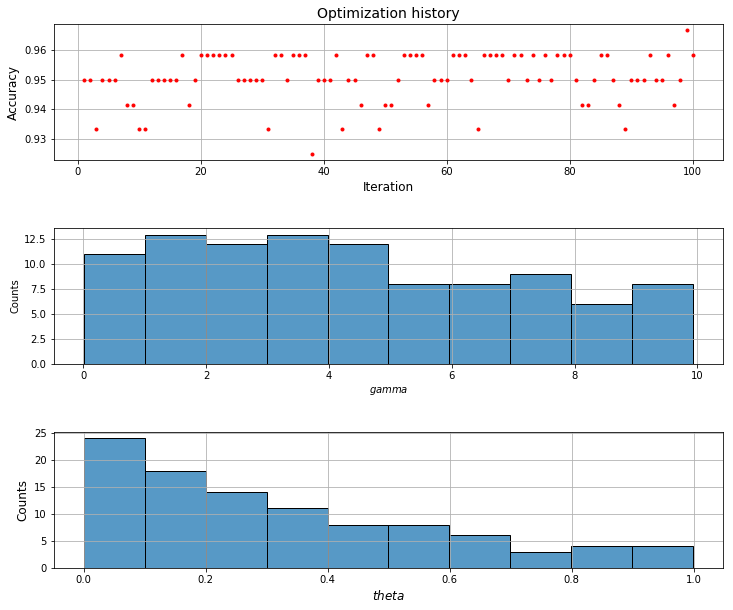

In [19]:
fig0 = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(nrows=3, ncols=1, hspace=0.5,wspace=0.3)

# ================================
# Plotting optimization history

ax = fig0.add_subplot(gs[0, 0])
ax.plot(range(1, len(trials_clf) + 1), [-x['result']['loss'] for x in trials_clf], 
        color='red', marker='.', linewidth=0)

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Optimization history', fontsize=14)

ax.grid(True)

# ================================
# Plotting sampled points

samples = [f_unpack_dict(f_wrap_space_eval(hp_space_gfmm, x)) for x in trials_clf.trials]

ax = fig0.add_subplot(gs[1, 0])
sns.histplot(x=[x['gamma'] for x in samples], bins=10, ax=ax)

ax.set_xlabel('$gamma$', fontsize=10)
ax.set_ylabel('Counts', fontsize=10)

ax.grid(True)

# ----------------

ax = fig0.add_subplot(gs[2, 0])
sns.histplot(x=[x['theta'] for x in samples], bins=10, ax=ax)

ax.set_xlabel('$theta$', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

ax.grid(True)